## Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
from scipy import stats

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, \
                            roc_auc_score, r2_score, mean_squared_error, average_precision_score, \
                            precision_recall_curve, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.tree import export_graphviz
import graphviz

from pydot import graph_from_dot_file

from scipy.stats import randint, uniform

plt.style.use('ggplot')

In [27]:
X = pd.read_csv('/content/drive/MyDrive/CMF/2021-bank-scoring-case-2/X_train.csv')

In [28]:
y = pd.read_csv('/content/drive/MyDrive/CMF/2021-bank-scoring-case-2/y_train.csv')['target'].astype('int')

In [29]:
X_test_check = pd.read_csv('/content/drive/MyDrive/CMF/2021-bank-scoring-case-2/X_test.csv').drop('index', axis=1)
X_test_checks = pd.read_csv('/content/drive/MyDrive/CMF/2021-bank-scoring-case-2/X_test.csv')

In [ ]:
def del_outliers(X):

    needed = ['credit_card_utilization', 'overdue_30_59_days',  'family_members', 'credits_loans', 'monthly_income', 'debt_to_income']

    for column in needed:

        if column in ['credit_card_utilization', 'overdue_30_59_days']:

                quantile1 = 0.05
                quantile3 = 0.95 

        if column in ['family_members', 'credits_loans', 'monthly_income', 'debt_to_income']:
            
                quantile1 = 0.1
                quantile3 = 0.9
            
        q1 = X[column].quantile(quantile1)
        q3 = X[column].quantile(quantile3)

        IQR = q3 - q1

        c = X.loc[(X[column] < q1 - 3 * IQR) | (X[column] > 3 * IQR + q3)].index
        X.drop(labels = c, inplace = True)
        y.drop(labels = c, inplace = True)

    return X.shape

In [ ]:
def set_threshold(threshold, y_pred_proba):
    y_w_threshold = []
    for i in y_pred_proba:
        if i > threshold:
            y_w_threshold.append(1)
        else:
            y_w_threshold.append(0)
    return y_w_threshold

## EDA

There are NaN in such columns as monthly_income, family_members

In [ ]:
nan_ratio(X)

monthly_income NaN proportion: 0.2
family_members NaN proportion: 0.03


In [ ]:
nan_ratio(X_test_check)

monthly_income NaN proportion: 0.19
family_members NaN proportion: 0.02


Replacing NaN in each column with the mean of this column 

In [ ]:
for df in [X, X_test_check]:
    income_mean = df['monthly_income'].mean()
    family_members_mean = df['family_members'].mean()
    df['monthly_income'] = df['monthly_income'].fillna((df['monthly_income'].mean()))
    df['family_members'] = df['family_members'].fillna((df['family_members'].mean()))

In [ ]:
X.shape

(105109, 10)

Delete outliers

*   4037 elements were considered to be outliers






In [ ]:
del_outliers(X)

(103288, 10)

Correlation between features is visualized

There is no multicollinearity 

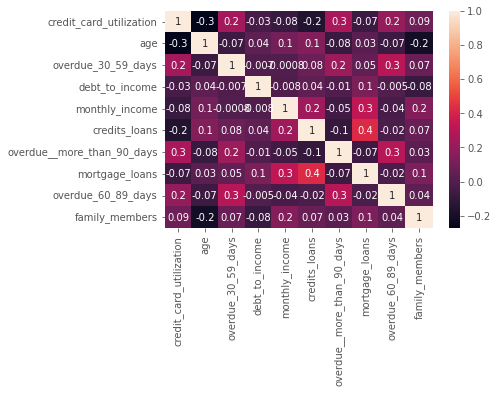

In [ ]:
sns.heatmap(X.corr(), annot=True, fmt='.1g')
plt.show()

Histograms are created 


 In the column age mean equals to 53.3


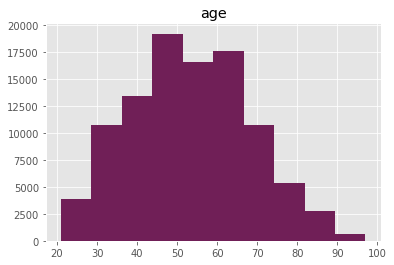


 In the column credits_loans mean equals to 8.66


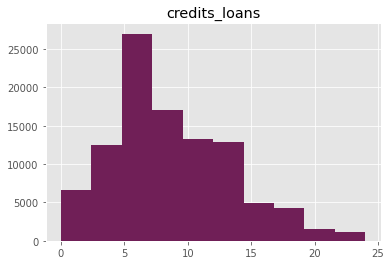


 In the column family_members mean equals to 0.73


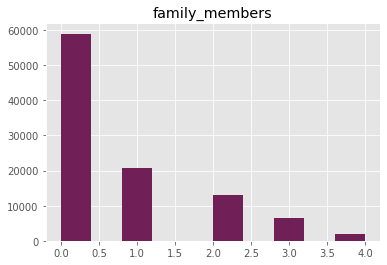

In [ ]:
for column in ['age', 'credits_loans', 'family_members']:
    plt.hist(X[column], bins=10, color=sns.color_palette("rocket")[1])
    mean = np.mean(X[column])
    print(f'\n In the column {column} mean equals to {round(mean, 2)}')
    plt.title(column)
    plt.show()


0 == will not ovedue more than 90 days <br> 
1 == will overdue

## Models 

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_test_check = StandardScaler().fit_transform(X_test_check)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=666)

In [ ]:
X_train.mean(axis=0)

array([-0.00133092,  0.00090989, -0.00074949, -0.00224235,  0.0012922 ,
        0.0008786 , -0.00048085,  0.00080949, -0.00144609, -0.00047297])

### Logistic Regression

This model is used only for classification tasks

In [ ]:
logreg = LogisticRegression()

Prediction of X_test


In [ ]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:,1] #probability to have 1 

ROC Curve

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

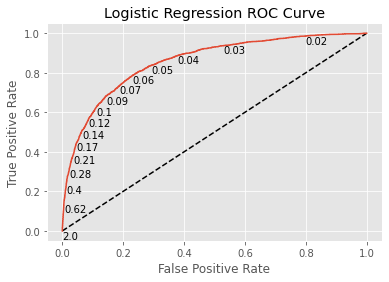

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')

for x, y, txt in zip(fpr[::200], tpr[::200], thresholds[::200]):
    plt.annotate(np.round(txt,2), (x, y-0.04))

plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

In [ ]:
y_pred_proba_w_thr = set_threshold(0.06, y_pred_proba) 

In [ ]:
print('AUC = ', round(roc_auc_score(y_test, y_pred_proba_w_thr), 2))

AUC =  0.78


In [ ]:
print(classification_report(y_test, y_pred_proba_w_thr))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84     28947
           1       0.18      0.82      0.29      2040

    accuracy                           0.73     30987
   macro avg       0.58      0.78      0.56     30987
weighted avg       0.93      0.73      0.80     30987



Prediction of X_test on Kaggle

In [ ]:
y_pred_proba_test = logreg.predict_proba(X_test_check)[:,1]

In [ ]:
df_test = pd.DataFrame()
df_test['index'] = X_test_checks['index'] 
df_test['target'] = y_pred_proba_test
df_test.to_csv('logreg1.csv', index = False) 

Hyperparameters tuning

In [ ]:
c_space = [0.001, 0.01, 0.1, 1, 1.5, 3, 5, 10] 
param_dist = {'C' : c_space}


In [ ]:
#from pandas.core.common import random_state
logreg_cv = GridSearchCV(logreg, param_dist, cv=5, error_score='raise')
logreg_cv.fit(X, y)
print("Tuned Log Reg Parameters: {}".format(logreg_cv.best_params_))

Tuned Log Reg Parameters: {'C': 1}


In [ ]:
logreg_cv_best = logreg_cv.best_estimator_

In [ ]:
logreg_cv_best

LogisticRegression(C=1)

Prediction of X_test


In [ ]:
y_pred_proba = logreg_cv_best.predict_proba(X_test)[::,1]
y_pred = logreg_cv_best.predict(X_test)

ROC Curve

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

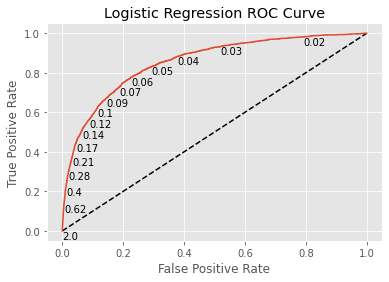

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')

for x, y, txt in zip(fpr[::200], tpr[::200], thresholds[::200]):
    plt.annotate(np.round(txt,2), (x, y-0.04))

plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

In [ ]:
y_w_threshold = set_threshold(0.06, y_pred_proba)

Model evaluation

In [ ]:
print('AUC =', round(roc_auc_score(y_test, y_w_threshold), 2))
print('APS =', round(average_precision_score(y_test, y_w_threshold), 2))

AUC = 0.78
APS = 0.17


In [ ]:
print(classification_report(y_test, y_w_threshold))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87     28938
           1       0.20      0.78      0.31      2040

    accuracy                           0.78     30978
   macro avg       0.59      0.78      0.59     30978
weighted avg       0.93      0.78      0.83     30978



Features mentioned below have the largest impact on the outcome

*   overdue__more_than_90_days
*   overdue_30_59_days
*   overdue_60_89_days





In [ ]:
model_coefficients = logreg_cv_best.coef_[0]

# Create a dataframe of the variables and coefficients & print it out
coefficient_df = pd.DataFrame({"Variable" : X_values, "Coefficient": model_coefficients})

# Print out the top 3 positive variables
top_three_df = coefficient_df.sort_values(by='Coefficient', axis=0, ascending=False)[0:3].set_index(pd.Index([1,2,3]))
print(top_three_df)

                     Variable  Coefficient
1     credit_card_utilization     0.489921
2  overdue__more_than_90_days     0.299325
3          overdue_30_59_days     0.286984


Prediction of X_test on Kaggle


In [ ]:
X_test_check = StandardScaler().fit_transform(X_test_check)

In [ ]:
y_pred_proba = logreg_cv_best.predict_proba(X_test_check)[::, 1]

In [ ]:
df_test = pd.DataFrame()
df_test['index'] = X_test_checks['index'] 
df_test['target'] = y_pred_proba

In [ ]:
df_test.to_csv('logreg.csv', index = False) 

### KNN

Hyperparameter tuning

In [ ]:
c_space = np.logspace(-5, 8, 15)

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 20),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}
knn_cv = RandomizedSearchCV(knn, param_grid, cv=5, random_state=12, refit=True)
knn_cv.fit(X, y)
knn_cv.best_params_

{'algorithm': 'brute', 'n_neighbors': 18, 'p': 1}

In [ ]:
knn_cv_best = knn_cv.best_estimator_ 

Prediction of X_test

In [ ]:
knn_cv_best.fit(X_train, y_train)
y_pred_proba_tr = knn_cv_best.predict_proba(X_test)[::, 1]

ROC Curve

Text(0.5, 1.0, 'Random Forest ROC Curve')

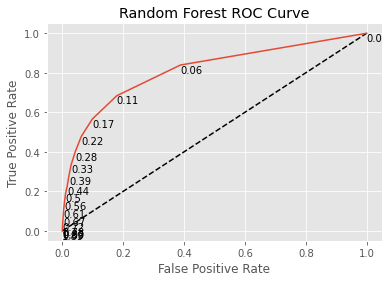

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_tr)
plt.plot([0,1], [0,1], 'k--')

for x, y, txt in zip(fpr, tpr, thresholds):
    plt.annotate(np.round(txt,2), (x, y-0.04))

plt.plot(fpr, tpr, label='Random Forest Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')

In [ ]:
y_pred_tr_w_thr = set_threshold(0.17, y_pred_proba_tr)

Model evaluation

In [ ]:
print(classification_report(y_test, y_pred_tr_w_thr))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     28938
           1       0.21      0.68      0.32      2040

    accuracy                           0.81     30978
   macro avg       0.59      0.75      0.61     30978
weighted avg       0.92      0.81      0.85     30978



In [ ]:
print('AUC = ', round(roc_auc_score(y_test, y_pred_tr_w_thr), 2))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_tr_w_thr)

AUC =  0.71


Precision Recall Curve

Text(0, 0.5, 'Recall')

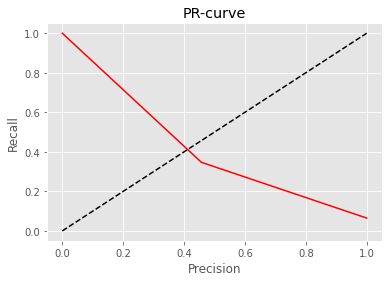

In [ ]:
fig, ax = plt.subplots()
ax.plot(recall, precision, c='r')
ax.plot([0, 1], [0, 1], linestyle='--', color='black')

ax.set_title('PR-curve')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

Prediction of X_test on Kaggle


In [ ]:
y_pred_proba = knn_cv_best.predict_proba(X_test_check)[::, 1]

In [ ]:
df_test = pd.DataFrame()
df_test['index'] = X_test_checks['index'] 
df_test['target'] = y_pred_proba

In [ ]:
df_test.to_csv('knn.csv', index = False) 

### Decision Tree

Hyperparameters Tuning

In [ ]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_leaf": randint(1, 11),
              "criterion": ["gini", "entropy"]}

In [ ]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5, random_state=33, refit=True)
tree_cv.fit(X, y)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88287fe250>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f882882f790>},
                   random_state=33)

In [ ]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(round(tree_cv.best_score_, 2)))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 7}
Best score is 0.94


In [ ]:
tree_best = DecisionTreeClassifier(criterion='gini', max_depth= 3, max_features=7, min_samples_leaf=7)

In [ ]:
tree_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_features=7, min_samples_leaf=7)

In [ ]:
tree_best = tree_cv.best_estimator_

Prediction of X_test


In [ ]:
y_pred = tree_best.predict(X_test)
y_pred_proba = tree_best.predict_proba(X_test)[:,1]

Text(0.5, 1.0, 'Decision Tree ROC Curve')

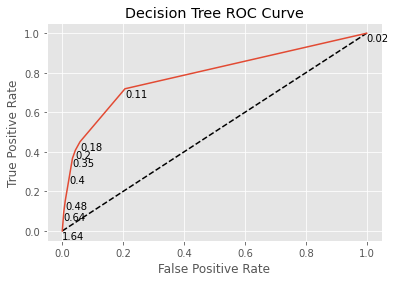

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')

for x, y, txt in zip(fpr, tpr, thresholds):
    plt.annotate(np.round(txt,2), (x, y-0.04))

plt.plot(fpr, tpr, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')

In [ ]:
y_pred_w_threshold = set_threshold(0.11, y_pred_proba)

Model evaluation

In [ ]:
print(classification_report(y_test, y_pred_w_threshold)) 

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     28938
           1       0.20      0.72      0.31      2040

    accuracy                           0.79     30978
   macro avg       0.59      0.76      0.59     30978
weighted avg       0.92      0.79      0.84     30978



In [ ]:
print(round(roc_auc_score(y_test, y_pred_w_threshold), 2))

0.76


Prediction of X_test on Kaggle


In [ ]:
y_pred_proba = tree_best.predict_proba(X_test_check)[:, 1]

In [ ]:
df_test = pd.DataFrame()
df_test['index'] = X_test_checks['index'] 
df_test['target'] = y_pred_proba

In [ ]:
df_test.to_csv('tree.csv', index = False) 

### Random Forest

Hyperparameters Tuning

In [ ]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_leaf": randint(1, 11),
              "criterion": ["gini", "entropy"],
              'max_depth': randint(1, 11)}
              #'n_estimators': np.arange(300, 1000, 100)}

In [ ]:
rf_clf_cv = RandomizedSearchCV(rf_clf, param_dist, cv=5, random_state=0, refit=True)
rf_clf_cv.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d88593750>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d88593550>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d885935d0>},
                   random_state=0)

In [ ]:
rf_clf_cv_best = rf_clf_cv.best_estimator_

Prediction of X_test 


In [ ]:
y_pred_prob_cv = rf_clf_cv_best.predict_proba(X_test)[:, 1] 

In [ ]:
print("Tuned Random Forest Parameters: {}".format(rf_clf_cv.best_params_))
print("Best score is {}".format(round(rf_clf_cv.best_score_, 2)))

Tuned Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 9, 'min_samples_leaf': 9}
Best score is 0.94


ROC Curve

Text(0.5, 1.0, 'Random Forest ROC Curve')

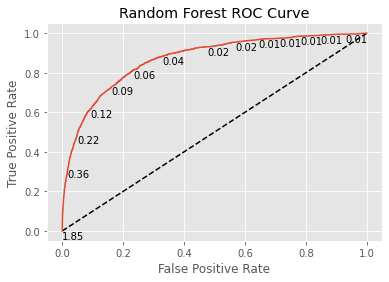

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_cv)
plt.plot([0,1], [0,1], 'k--')

for x, y, txt in zip(fpr[::500], tpr[::500], thresholds[::500]):
    plt.annotate(np.round(txt,2), (x, y-0.04))

plt.plot(fpr, tpr, label='Random Forest Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')

In [ ]:
y_pred_cv_w_threshold = set_threshold(0.06, y_pred_prob_cv)

 Model evaluation 

In [ ]:
print(classification_report(y_test, y_pred_cv_w_threshold))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86     28938
           1       0.20      0.81      0.32      2040

    accuracy                           0.77     30978
   macro avg       0.59      0.79      0.59     30978
weighted avg       0.93      0.77      0.83     30978



In [ ]:
print('ROC-AUC =', round(roc_auc_score(y_test, y_pred_cv_w_threshold), 2))

AUC = 0.79


Prediction of X_test on Kaggle


In [ ]:
y_pred_proba = tree_best.predict_proba(X_test_check)[:, 1]

MSE = 0.31


In [ ]:
df_test = pd.DataFrame()
df_test['index'] = X_test_checks['index'] 
df_test['target'] = y_pred_proba

In [ ]:
df_test.to_csv('rf.csv', index = False) 

### CatBoost 

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [ ]:
from catboost import CatBoostClassifier

Feature Tuning

In [ ]:
model = CatBoostClassifier()
param_dist = {'depth'         : randint(4, 10),
              'learning_rate' : uniform(),
              'iterations'    : randint(10, 100),
              'l2_leaf_reg'   : randint(1, 100)}
    
catboost_cv = RandomizedSearchCV(estimator=model, param_distributions = param_dist, 
                               cv = 5, n_iter = 10, n_jobs=-1, refit=True)
catboost_cv.fit(X_train, y_train)

0:	learn: 0.5965009	total: 64.3ms	remaining: 5.59s
1:	learn: 0.5219936	total: 76.3ms	remaining: 3.28s
2:	learn: 0.4639517	total: 85.1ms	remaining: 2.41s
3:	learn: 0.4160928	total: 95.1ms	remaining: 2s
4:	learn: 0.3773833	total: 107ms	remaining: 1.77s
5:	learn: 0.3452266	total: 117ms	remaining: 1.6s
6:	learn: 0.3191134	total: 127ms	remaining: 1.47s
7:	learn: 0.2967063	total: 137ms	remaining: 1.37s
8:	learn: 0.2784265	total: 148ms	remaining: 1.3s
9:	learn: 0.2629723	total: 158ms	remaining: 1.23s
10:	learn: 0.2497784	total: 168ms	remaining: 1.18s
11:	learn: 0.2385653	total: 178ms	remaining: 1.13s
12:	learn: 0.2293954	total: 189ms	remaining: 1.09s
13:	learn: 0.2218987	total: 200ms	remaining: 1.06s
14:	learn: 0.2152779	total: 210ms	remaining: 1.02s
15:	learn: 0.2096723	total: 220ms	remaining: 989ms
16:	learn: 0.2046627	total: 230ms	remaining: 961ms
17:	learn: 0.2006915	total: 240ms	remaining: 933ms
18:	learn: 0.1974655	total: 250ms	remaining: 907ms
19:	learn: 0.1945663	total: 265ms	remainin

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f2d7ca6de50>,
                   n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d7ca6d6d0>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d885fe050>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d7ca6d110>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d7ca6d350>})

In [ ]:
catboost_cv.fit(X_train, y_train)

0:	learn: 0.5250313	total: 19.7ms	remaining: 1.63s
1:	learn: 0.4208993	total: 36ms	remaining: 1.48s
2:	learn: 0.3521434	total: 50.2ms	remaining: 1.35s
3:	learn: 0.3039016	total: 58.5ms	remaining: 1.17s
4:	learn: 0.2694416	total: 72.2ms	remaining: 1.14s
5:	learn: 0.2456845	total: 87.1ms	remaining: 1.13s
6:	learn: 0.2280067	total: 99.8ms	remaining: 1.1s
7:	learn: 0.2148435	total: 113ms	remaining: 1.08s
8:	learn: 0.2051980	total: 127ms	remaining: 1.06s
9:	learn: 0.1979717	total: 142ms	remaining: 1.05s
10:	learn: 0.1929521	total: 157ms	remaining: 1.04s
11:	learn: 0.1887415	total: 171ms	remaining: 1.03s
12:	learn: 0.1855785	total: 188ms	remaining: 1.03s
13:	learn: 0.1836334	total: 202ms	remaining: 1.01s
14:	learn: 0.1821347	total: 217ms	remaining: 996ms
15:	learn: 0.1809604	total: 236ms	remaining: 1s
16:	learn: 0.1799248	total: 251ms	remaining: 988ms
17:	learn: 0.1789753	total: 266ms	remaining: 975ms
18:	learn: 0.1782824	total: 280ms	remaining: 959ms
19:	learn: 0.1777837	total: 295ms	remain

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f2d7ca46e10>,
                   n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d7ca46cd0>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d7ca6d150>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d7ca60650>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d7ca46e50>})

In [ ]:
catboost_cv_best = catboost_cv.best_estimator_

Prediction of X_test

In [ ]:
y_pred = catboost_cv_best.predict_proba(X_test)[::, 1]

ROC-Curve

Text(0.5, 1.0, 'CatBoost ROC Curve')

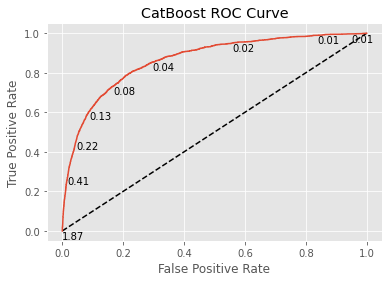

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')

for x, y, txt in zip(fpr[::500], tpr[::500], thresholds[::500]):
    plt.annotate(np.round(txt,2), (x, y-0.04))

plt.plot(fpr, tpr, label='CatBoost Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')

In [ ]:
y_pred_cv_w_threshold = set_threshold(0.04, y_pred)

 Model evaluation 

In [ ]:
print('ROC-AUC =', round(roc_auc_score(y_test, y_pred_cv_w_threshold), 2))

ROC-AUC = 0.78


In [ ]:
print(classification_report(y_test, y_pred_cv_w_threshold))

              precision    recall  f1-score   support

           0       0.99      0.69      0.82     28938
           1       0.17      0.86      0.28      2040

    accuracy                           0.71     30978
   macro avg       0.58      0.78      0.55     30978
weighted avg       0.93      0.71      0.78     30978



Prediction of X_test on Kaggle

In [ ]:
y_pred_proba = catboost_cv_best.predict_proba(X_test_check)[::, 1]

In [ ]:
df_test = pd.DataFrame()
df_test['index'] = X_test_checks['index'] 
df_test['target'] = y_pred_proba

In [ ]:
df_test.to_csv('catboost.csv', index = False) 

### Ensemble Method

In [ ]:
clf_voting = VotingClassifier(
    estimators = [('catboost', catboost_cv_best),
                  ('logreg', logreg),
                  ('knn', knn_cv_best)], voting='soft',
)

In [ ]:
clf_voting.fit(X_train, y_train)

0:	learn: 0.5250313	total: 17.7ms	remaining: 1.47s
1:	learn: 0.4208993	total: 31.8ms	remaining: 1.3s
2:	learn: 0.3521434	total: 45.3ms	remaining: 1.22s
3:	learn: 0.3039016	total: 53.5ms	remaining: 1.07s
4:	learn: 0.2694416	total: 67.1ms	remaining: 1.06s
5:	learn: 0.2456845	total: 82.2ms	remaining: 1.07s
6:	learn: 0.2280067	total: 94.6ms	remaining: 1.04s
7:	learn: 0.2148435	total: 108ms	remaining: 1.02s
8:	learn: 0.2051980	total: 122ms	remaining: 1.01s
9:	learn: 0.1979717	total: 136ms	remaining: 1.01s
10:	learn: 0.1929521	total: 151ms	remaining: 1s
11:	learn: 0.1887415	total: 166ms	remaining: 996ms
12:	learn: 0.1855785	total: 182ms	remaining: 996ms
13:	learn: 0.1836334	total: 197ms	remaining: 984ms
14:	learn: 0.1821347	total: 211ms	remaining: 970ms
15:	learn: 0.1809604	total: 229ms	remaining: 975ms
16:	learn: 0.1799248	total: 251ms	remaining: 990ms
17:	learn: 0.1789753	total: 267ms	remaining: 977ms
18:	learn: 0.1782824	total: 285ms	remaining: 976ms
19:	learn: 0.1777837	total: 300ms	rema

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7f2d7c9fd610>),
                             ('logreg', LogisticRegression()),
                             ('knn',
                              KNeighborsClassifier(algorithm='brute',
                                                   n_neighbors=18, p=1))],
                 voting='soft')

Prediction of X_test

In [ ]:
#y_pred = clf_voting.predict(X_test)
y_pred_prob = clf_voting.predict_proba(X_test)[::, 1]

ROC Curve

Text(0.5, 1.0, 'Random Forest ROC Curve')

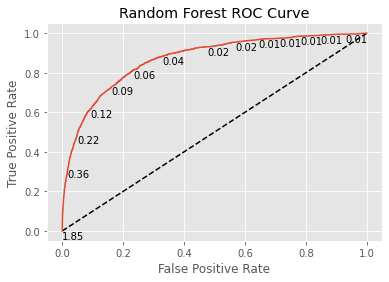

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_cv)
plt.plot([0,1], [0,1], 'k--')

for x, y, txt in zip(fpr[::500], tpr[::500], thresholds[::500]):
    plt.annotate(np.round(txt,2), (x, y-0.04))

plt.plot(fpr, tpr, label='Random Forest Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')

In [ ]:
y_pred_proba_w_thr = set_threshold(0.12, y_pred_prob)

In [ ]:
print(classification_report(y_test, y_pred_proba_w_thr))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     28938
           1       0.31      0.60      0.41      2040

    accuracy                           0.89     30978
   macro avg       0.64      0.75      0.67     30978
weighted avg       0.93      0.89      0.90     30978



In [ ]:
print('ROC-AUC =', round(roc_auc_score(y_test, y_pred_cv_w_threshold), 2))

ROC-AUC = 0.78


Prediction of X_test on Kaggle


In [ ]:
y_pred_proba = clf_voting.predict_proba(X_test_check)[::, 1]

In [ ]:
df_test = pd.DataFrame()
df_test['index'] = X_test_checks['index'] 
df_test['target'] = y_pred_proba


In [ ]:
df_test.to_csv('ensemble.csv', index = False) 